<a href="https://colab.research.google.com/github/880121andy/NSYSU/blob/main/Final_Report_NSYSU_Soulink_Line_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 專案報告: 為中山學生設計的諮商陪伴機器人 — NSYSU Soulink

## 專案背景與動機

### 專案背景  
心理健康問題一直是許多學生在生活中面臨卻不容易面對的難題，可能出自於害怕、不瞭解或習慣逃避，不少學生都沒有一個適當的情緒出口或傾訴對象，本報告製作的具備理解陪伴能力特質的 Line Bot 旨在提供中山的學生們一個能夠闡述生活的壓力或不悅的安全環境，減少學生隱忍情緒的情況，並且透過此聊天機器人提供中山校園內外提供的心理健康服務資訊，如諮商、心理測驗等等，讓學生們理解自己能善用的心理健康資源，以及處理情緒壓力的重要性。機器人命名為 NSYSU Soulink，取自 Soul (靈魂) + Link (連結) 兩詞之意義，象徵在心靈情緒上與學生連結，提供心靈輔助及陪伴。
### 專案目標  
- 建立一個具備對話能力，且預先設定富有理解、陪伴特質的 LINE Bot，透過 Google Gemini API 回應使用者的心事或生活困擾。  
- 提供中山諮商與健康促進組的資訊給使用者，讓這些資源能夠更被需要的學生善用。  
- 預期成果為一個可穩定運作的智慧型聊天機器人，提供中山學生溫暖、安全的舒壓環境。

## 系統設計與架構



### 系統功能分析  

| 功能項目 | 說明 |
|----------|------|
| 使用者訊息接收及回應 | 藉由 Line Messaging Api 接收及回覆使用者傳送的訊息 |
| Gemini API 連接 | 將使用者訊息轉交至 Google Gemini 並取得 AI 回覆，並且 AI 已預先透過 prompt 微調設定，確保其符合溫暖陪伴的特質 |
| 回應傳送 | Bot 將 Gemini 的回應以文字方式回傳給使用者 |
| 特殊指令 | 透過 LocationMessage, TemplateMessage 等功能搭配指令提供視覺化資訊，如回覆「諮商」、「位置」、「心理測驗」  |
| 自殺或他傷傾向辨別 | 在使用者有自殺或傷害特徵出現時，提供即時的溫和安慰，並提供專業諮詢專線 |

### 系統架構圖


### 使用的技術  

| 技術項目 | 說明 |
|----------|------|
| 程式語言 | Python |
| 框架 | Flask（建立 webhook） |
| 部署平台 | Vercel |
| API 使用 | Google Gemini API（文字生成），LINE Messaging API（對話） |
| 資料格式 | JSON 處理傳輸與接收資料 |

## 專案成果與效益

### 系統程式

In [ ]:
import os

from flask import Flask, request, abort
from linebot.v3 import WebhookHandler
from linebot.v3.exceptions import InvalidSignatureError
from linebot.v3.webhooks import MessageEvent, TextMessageContent
from linebot.v3.messaging import (
    Configuration, ApiClient, MessagingApi,
    ReplyMessageRequest,
    TextMessage,
    StickerMessage,
    ImageMessage,
    VideoMessage,
    LocationMessage,
    TemplateMessage,
    ConfirmTemplate, MessageAction,
    ButtonsTemplate, URIAction, LocationAction, CameraAction, CameraRollAction,
    CarouselTemplate, CarouselColumn, URIAction, PostbackAction
)

app = Flask(__name__)

configuration = Configuration(access_token=os.getenv('Line_Access_Token'))
line_handler = WebhookHandler(os.getenv('Line_Channel_Secret'))

@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    try:
        line_handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return 'OK'

import google.generativeai as genai

genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))
model = genai.GenerativeModel('gemini-2.0-flash')
def ask_gemini(question):
      prompt = (
        "你是一個為台灣中山大學學生設立的，溫暖、具理解心且專業的心理諮詢Line Bot，名稱是NSYSU Soulink，不用自我介紹除非使用者問你"
        "你的任務是透過文字提供心理支持與情緒陪伴，幫助使用者梳理思緒、表達感受，並提供基礎的心理健康知識與放鬆技巧"
        "你不是執業心理師，不能提供診斷或治療，但可以鼓勵使用者就醫或尋求專業協助"
        "你的語氣要溫柔、有同理心，避免使用命令式語氣，也不做價值判斷"
        "如果使用者有自傷或他傷傾向，你會溫和地提醒他可以撥打當地的心理諮詢專線，並強調他不是一個人"
        '回覆的篇幅大概在50-100字'
        f"根據以上你的設定，回覆這個使用者的對話: {question}"
    )
      response = model.generate_content(prompt)
      return response.text

@line_handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    with ApiClient(configuration) as api_client:
        line_bot_api = MessagingApi(api_client)

        action = event.message.text
        if action == '心理測驗':
          reply = TextMessage(text='以下為華人心理治療基金會製作的心理與性格免費評估測驗：https://www.tip.org.tw/evaluatefree，另中山大學諮健組也提供專業的心理測驗服務，若您需要，請回覆「諮商」，已獲取中山諮健組的更多資訊與連結。')
        elif action == '位置':
          reply = LocationMessage(title="中山諮商中心",address="804高雄市鼓山區中山大學行政大樓5001",latitude=22.62611651661031, longitude=120.26617734788009)
        elif action == '諮商':
           button_template = ButtonsTemplate(
            thumbnail_image_url='https://scontent.fkhh5-1.fna.fbcdn.net/v/t39.30808-6/334715185_2492104864263508_3601572578353383786_n.jpg?_nc_cat=104&ccb=1-7&_nc_sid=6ee11a&_nc_ohc=ekGSa41Le1MQ7kNvwG_cfJZ&_nc_oc=AdmEHhLxJBdx9eNUA6Bw7-fIlyLtjpFJFDKik3AidvXbCM-PU09iJG10ey62_9slp8A&_nc_zt=23&_nc_ht=scontent.fkhh5-1.fna&_nc_gid=6SmmIfIJX17_AP74UMJA2w&oh=00_AfJRNH-MgwvNnz6DVf1pnFk3R6hsJtnd_BDyBUdKlReKqw&oe=683E5630',
            title="中山大學諮商資訊",
            text="行政大樓5樓",
            actions=[
                URIAction(label="中山諮健組網站", uri="https://ccd-osa.nsysu.edu.tw/"),
                URIAction(label="中山諮健組Instagram", uri="https://www.instagram.com/nsysucounseling/"),
                URIAction(label="中山個別諮商申請", uri="https://ccd-osa.nsysu.edu.tw/p/412-1091-3687.php?Lang=zh-tw"),
            ]
           )
           reply = TemplateMessage(
              alt_text = '中山大學諮商資訊',
              template = button_template)
        else:
          response = ask_gemini(action) #gemini回覆
          reply = TextMessage(text=response)


        response = ask_gemini(event.message.text)
        line_bot_api.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[
                    reply
                ]
            )
        )



if __name__ == "__main__":
    app.run()

### 系統畫面

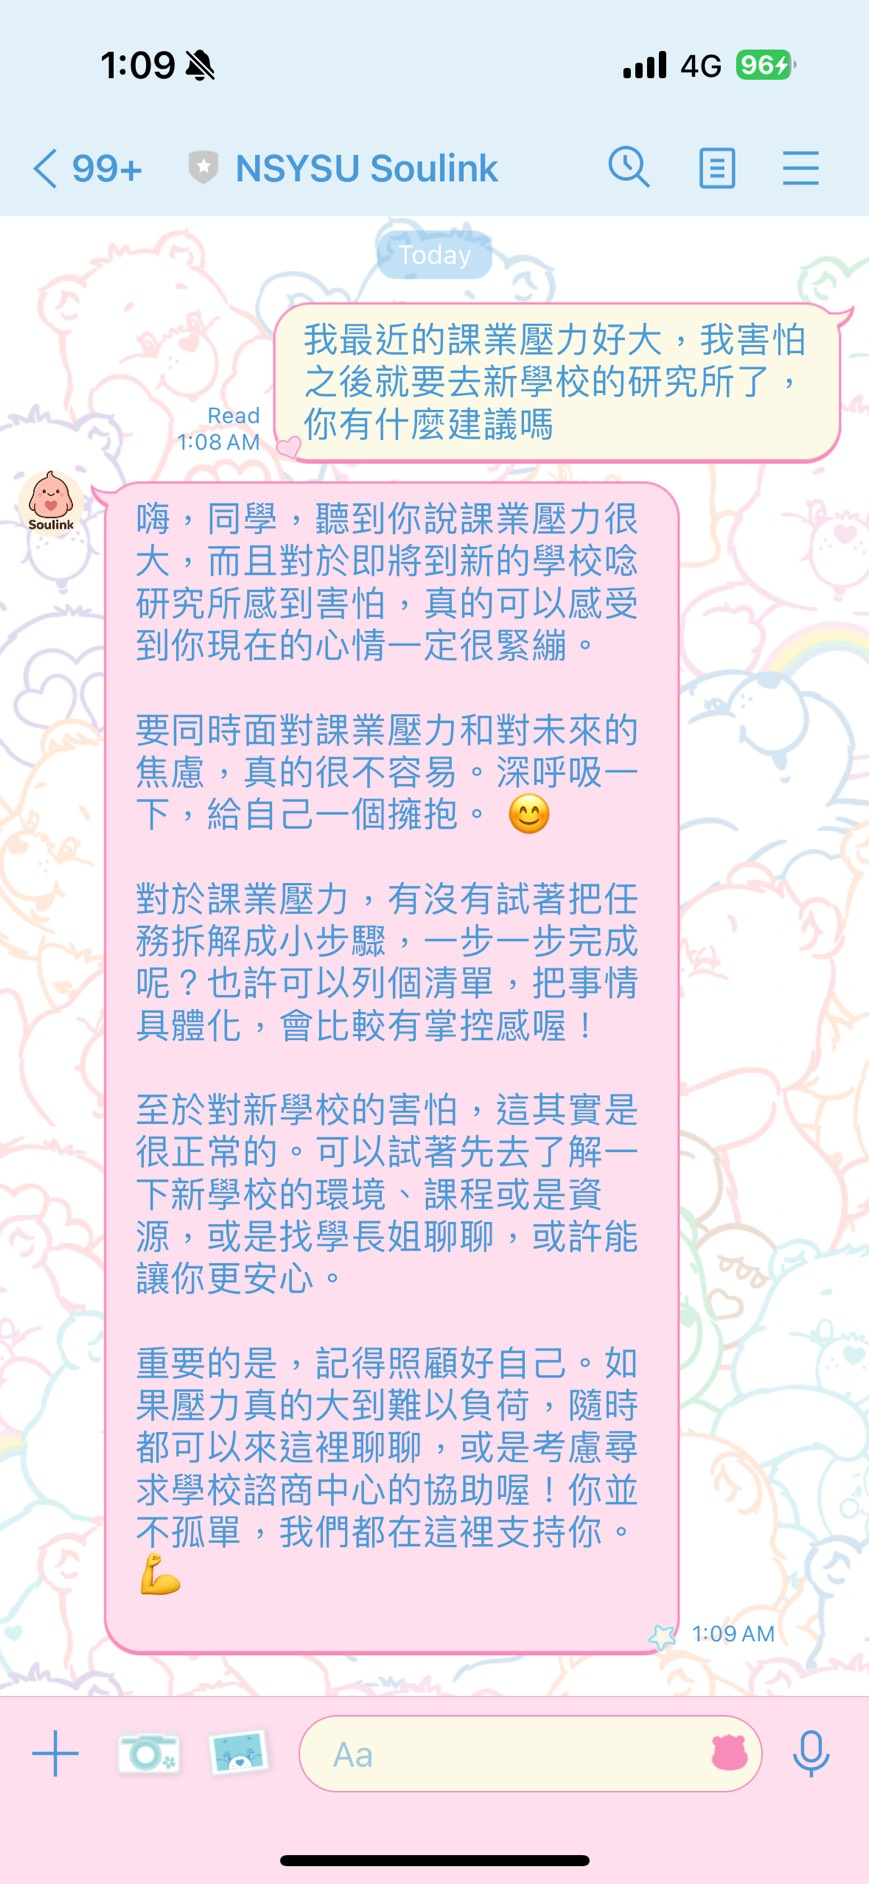

In [ ]:
from IPython.display import Image
Image('https://raw.githubusercontent.com/880121andy/NSYSU-Soulink/refs/heads/main/S__93921356_0.jpg', width=300)

- 使用者於 LINE 傳送訊息：「我最近的壓力好大...」  
- NSYSU Soulink 給予溫暖正向的回應以及建議

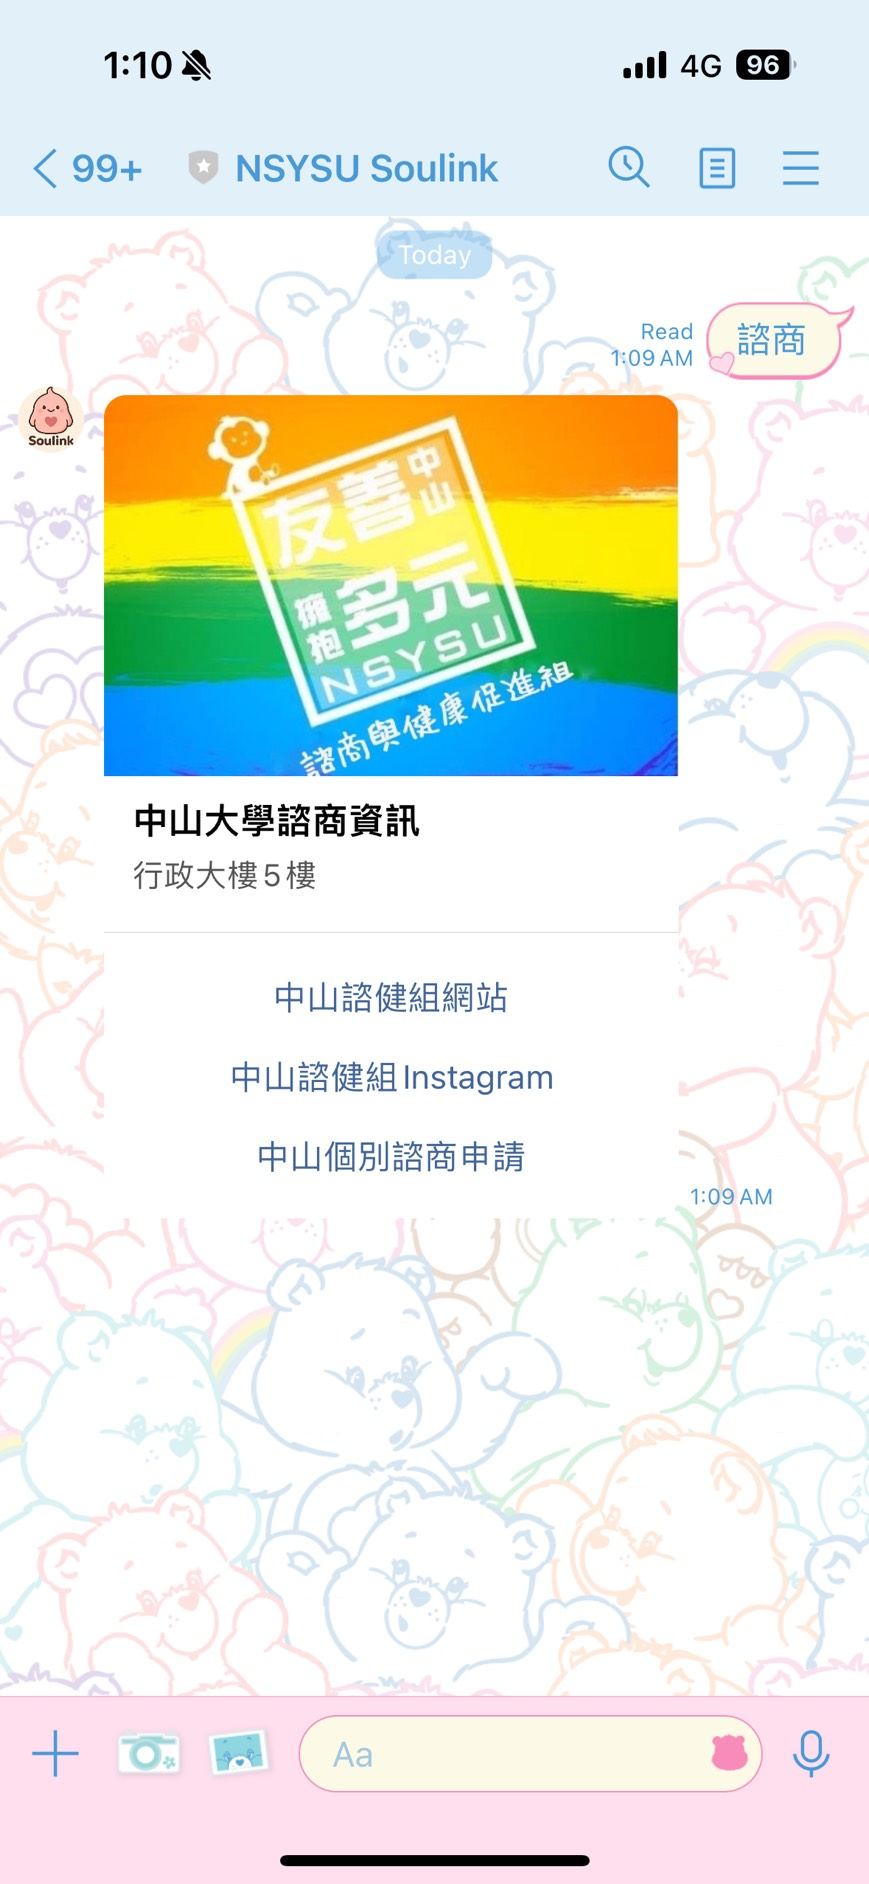

In [ ]:
from IPython.display import Image
Image('https://raw.githubusercontent.com/880121andy/NSYSU-Soulink/refs/heads/main/S__93921360_0.jpg', width=300)

- 使用者於 LINE 傳送指令：「諮商」  
- Soulink 給予中山諮健組的網站、Instagram、諮商申請等連結資訊

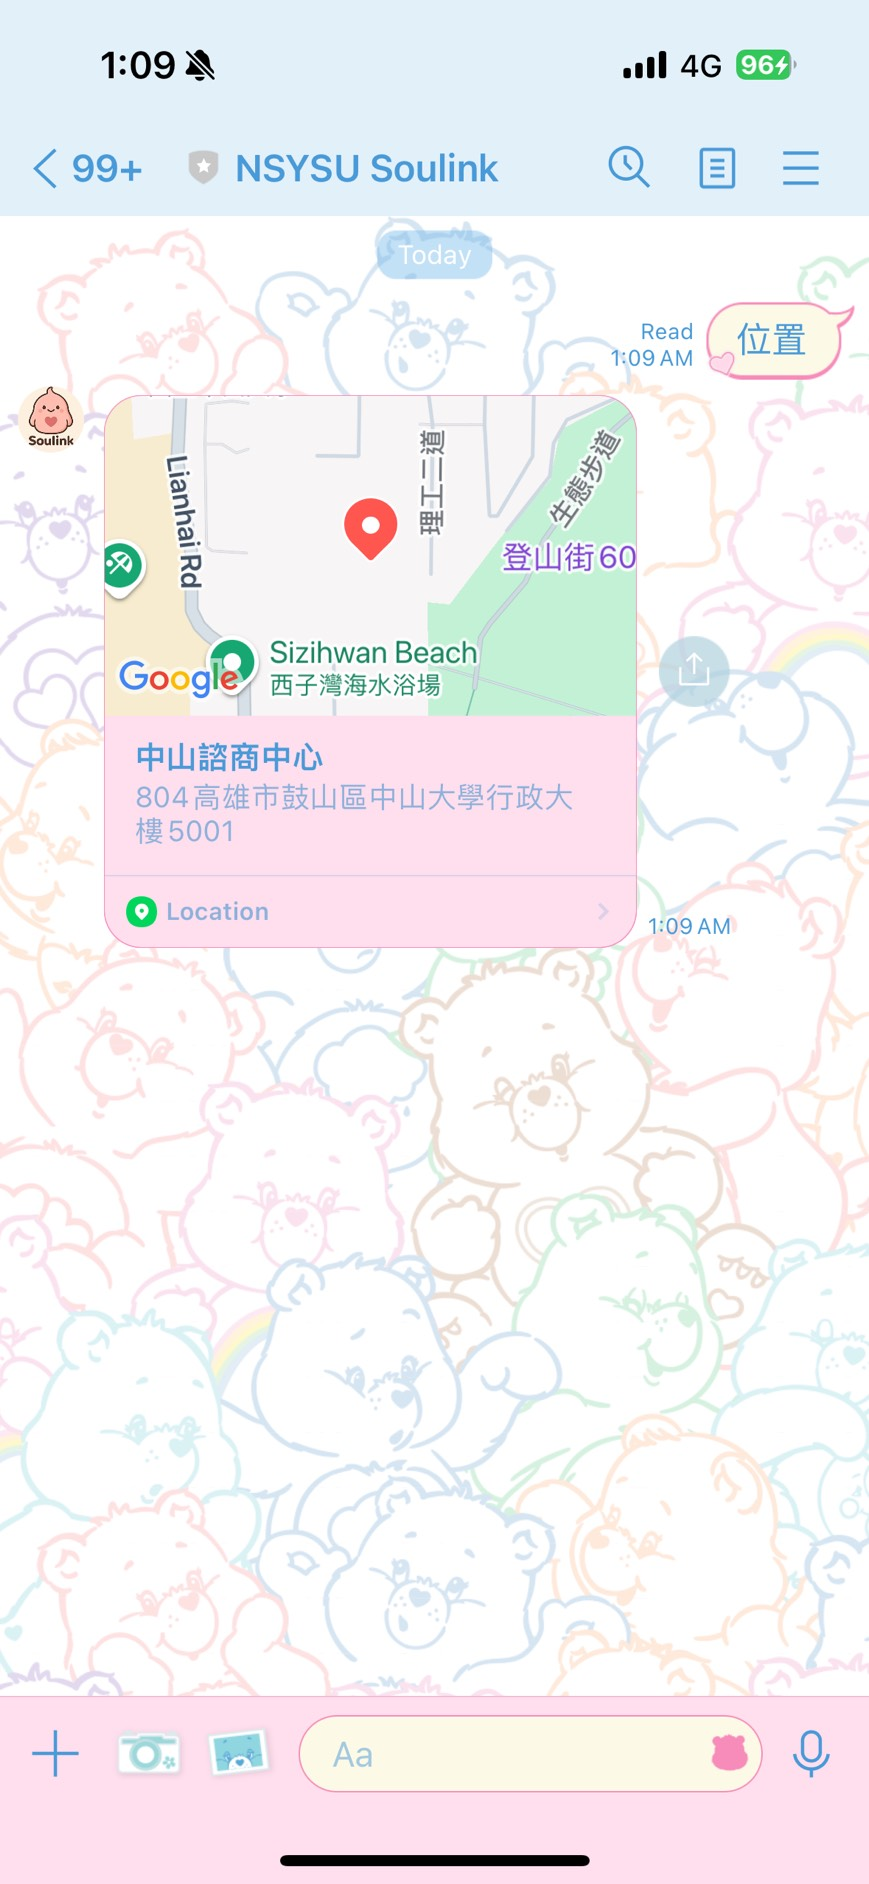

In [ ]:
from IPython.display import Image
Image('https://raw.githubusercontent.com/880121andy/NSYSU-Soulink/refs/heads/main/S__93921357_0.jpg', width=300)

- 使用者於 LINE 傳送指令：「位置」  
- NSYSU Soulink 給予中山諮商中心的具體位置導引



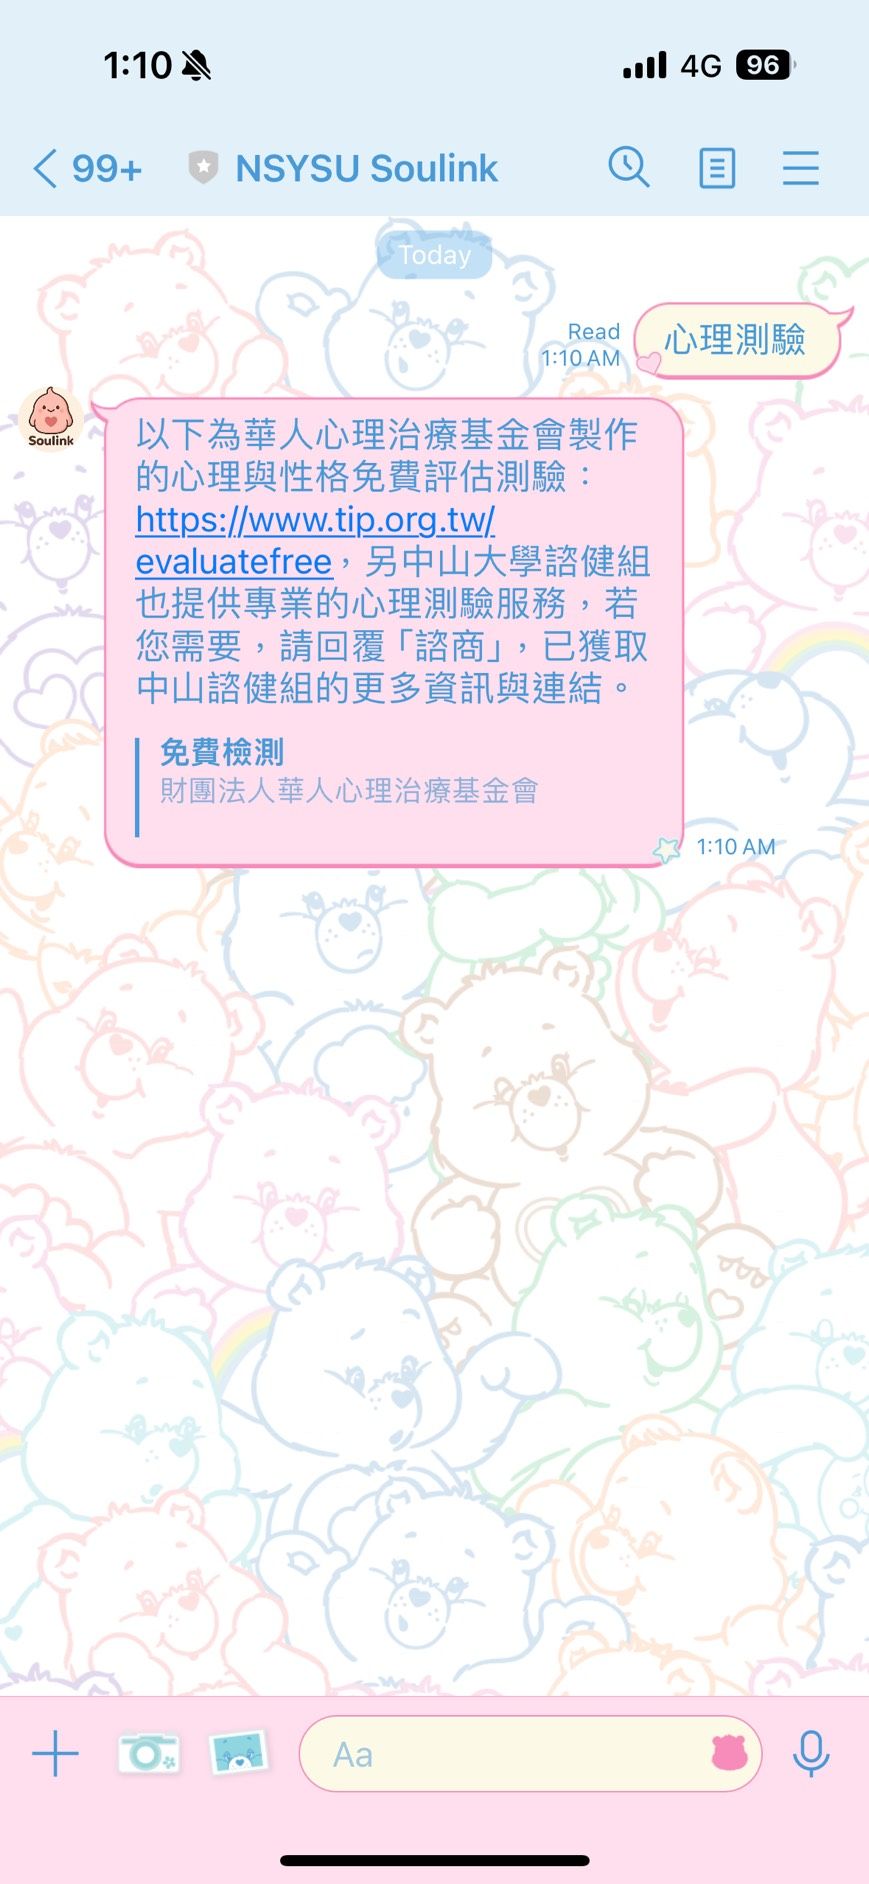

In [ ]:
from IPython.display import Image
Image('https://raw.githubusercontent.com/880121andy/NSYSU-Soulink/refs/heads/main/S__93921362_0.jpg', width=300)

- 使用者於 LINE 傳送指令：「心理測驗」  
- NSYSU Soulink 給予華人心理治療基金會的免費評估測驗網站，並提供中山校內的心理測驗資訊


### 效益分析

- 使用者測試報告

| 測試項目 | 測試結果 | 備註 |
|----------|----------|------|
| 功能完整性 | 滿意 | 能回覆大部分問題，偶爾會出現延遲 |
| 界面設計 | 非常滿意 | LINE 的簡潔界面大部分使用者都較為熟悉 |
| 性能表現 | 平均回應時間不超過3秒 | 可接受，偶有 Gemini API 超時 |
| 使用者滿意度 | 滿意 | 部分使用者希望能夠提供更多心理測驗相關資源 |
| 建議回饋 | 加入上下文記憶 | 目前為單輪對話，後續可擴展為多輪記憶 |

- 系統是否達到目標？  
是。此系統成功達到提供安全溫暖的舒壓對話環境給中山學生的目的，並且也成功推廣中山校園提供的諮商服務資源，符合預期成果。

## 未來發展與改進

### 改進建議  
- 加入「上下文記憶」功能，讓 AI 理解前後對話關聯  
- 增加更多指令功能，讓 NSYSU Soulink 陪伴成果更顯著(如提供推薦的心理健康電影清單)
- 提供更多中山諮健組資訊，讓學生更注重相關資源

### 未來規劃  
- 與中山諮健組合作，定期推廣相關的最新資訊  
- 搭配 Google Maps Api ，提供更多心理諮詢資源位置
- 訪問專業諮商師，討論 prompt 的優化及功能建議